<a href="https://colab.research.google.com/github/pojo-25/drugProject/blob/branchProjectTrial0/Copy_of_LSTMDropoutSequenceModelToProjectTox21withAUCSon4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np

In [ ]:
# col_smiles = 'canonical_smiles'
# col_target = 'bioactivity_class'

col_smiles = 'smiles'
col_target = 'SR-ATAD5'


METRIC_ACCURACY = 'accuracy'
METRIC_F1_SCORE = 'f1-score'
METRIC_COHEN_KAPPA = 'Cohen kappa'
METRIC_CONFUSION_MATRIX = 'Confusion Matrix'
METRIC_ROC_AUC = 'ROC_AUC'


CLASSES = ['benign', 'malignant']
TEST_RATIO = 0.2
SEED = 0

#data_path = '/content/data/abl_kinase-data.csv'
#data_path = '/content/data/HIV.csv'
data_path = '/content/data/tox21.csv'




In [ ]:
def read_data(data_path, col_smiles='smiles', col_target='SR-ATAD5'):
    """Split original data into train data and test data.
    :param data_path: str, path to the a CSV data file
    :param col_smiles: str, name of smiles column
    :param col_target: str, name of target column
    :param test_ratio: float, proportion of the original data for testset, must be from 0 to 1
    :param seed: int, randomization seed for reproducibility
    :return (X, y)
    """
    

    # read data
    df = pd.read_csv(data_path, sep=',')
    df_no_na = df[[col_smiles, col_target]].dropna()

    X = df_no_na[col_smiles]
    y = df_no_na[col_target].values

    # df['new_Bio'] = pd.factorize(df.bioactivity_class)[0]

    # df.head()

    # y = df['new_Bio'].values

    return X, y

                
def get_prediction_score(y_label, y_predict):
    """Evaluate predictions using different evaluation metrics.
    :param y_label: list, contains true label
    :param y_predict: list, contains predicted label
    :return scores: dict, evaluation metrics on the prediction
    """
    scores = {}
    scores[METRIC_ACCURACY] = accuracy_score(y_label, y_predict)
    scores[METRIC_ROC_AUC] = roc_auc_score(y_label, y_predict)
    scores[METRIC_F1_SCORE] = f1_score(y_label, y_predict, labels=None, average='macro', sample_weight=None)
    scores[METRIC_COHEN_KAPPA] = cohen_kappa_score(y_label, y_predict)
    scores[METRIC_CONFUSION_MATRIX] = confusion_matrix(y_label, y_predict)
    
    return scores

In [ ]:
import os
import sys
sys.path.insert(0, os.getcwd()) # add current working directory to pythonpath



import tensorflow as tf

from tensorflow.python.keras import backend as K
#os.environ["CUDA_VISIBLE_DEVICES"]="0" # Use only the 1st GPU
tf_config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=tf_config)
K.set_session(sess)


from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Conv1D, MaxPooling1D, GRU, Bidirectional
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


import warnings
import gc


In [ ]:
# import os
# import sys
# sys.path.insert(0, os.getcwd()) # add current working directory to pythonpath



# import keras.backend as K
# import numpy as np
# import tensorflow as tf
# from keras import callbacks
# from keras.optimizers import Adam
# from keras.models import load_model
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten
# from keras.layers import Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Conv1D, MaxPooling1D, GRU, Bidirectional
# from keras import optimizers
# from sklearn.model_selection import train_test_split
# from sklearn.utils import class_weight

# import warnings
# import argparse
# import gc


In [ ]:
def generate_tokens(smiles, len_percentile=100):
    """
    Generate character tokens from smiles
    :param smiles: Pandas series, containing smiles
    :param len_percentile: percentile of smiles length to set as max length
    :return tokens
    :return num_words
    :return max_phrase_len
    """ 
    
    # Get max length of smiles
    smiles_len = smiles.apply(lambda p: len(p))
    max_phrase_len = int(np.percentile(smiles_len, len_percentile))
    print('True max length is ' + str(np.max(smiles_len)) + ', ' + str(max_phrase_len) + ' is set the length cutoff.')
        
    # Get unique words
    unique_words = np.unique(np.concatenate(smiles.apply(lambda p: np.array(list(p))).values, axis=0))
    num_words = len(unique_words)
    print('Vocab size is ' + str(num_words))
    
    tokenizer = Tokenizer(
        num_words = num_words,
        filters = '$',
        char_level = True,
        oov_token = '_'
    )

    #print(num_words)
    
    tokenizer.fit_on_texts(smiles)
    sequences = tokenizer.texts_to_sequences(smiles)
    tokens = pad_sequences(sequences, maxlen = max_phrase_len, padding='post', truncating='post')
    
    return tokens, num_words, max_phrase_len

In [ ]:
smiles, y = read_data(data_path, col_smiles='smiles', col_target='SR-ATAD5')
tokens, num_words, max_phrase_len = generate_tokens(smiles, len_percentile=100)

True max length is 342, 342 is set the length cutoff.
Vocab size is 55


In [ ]:
def create_model(model_type, num_words, input_length, output_dim=1, dropout_rate=0.2):
    """Build different sequence model
    :param model_type: str, can be 'cnn-gru', 'cnn', 'gru', 'lstm'
    :param num_words: int
    :param input_length: int
    :param output_dim: int
    :return model: Keras model
    """ 
    
    model = Sequential()
    if model_type == 'lstm': # LSTM - LSTM
        model.add(Embedding(num_words+1, 50, input_length=input_length))
        #model.add(Conv1D(192,3,activation='relu'))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(128)))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim, activation='sigmoid'))
    elif model_type == 'gru': # GRU - GRU
        model.add(Embedding(num_words+1, 50, input_length=input_length))
        #model.add(Conv1D(192,3,activation='relu'))
        model.add(Bidirectional(GRU(128, return_sequences=True)))
        model.add(Bidirectional(GRU(128)))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim, activation='sigmoid'))
    elif model_type == 'cnn-gru': # 1D CNN - GRU
        model.add(Embedding(num_words+1, 50, input_length=input_length))
        #model.add(Conv1D(192,3,activation='relu'))
        model.add(Bidirectional(GRU(224, return_sequences=True)))
        model.add(Bidirectional(GRU(384)))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim, activation='sigmoid'))
    elif model_type == 'cnn': # 1D CNN
        model.add(Embedding(num_words+1, 50, input_length=input_length))
        model.add(Conv1D(192, 10, activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv1D(192, 3, activation='relu'))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(output_dim, activation='sigmoid'))
    else:
        raise ValueError(model_type + ' is not supported.')
 
    model.summary()    
    return model

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def build_sequence_model(trainset, testset, model_type, num_words, input_length, output_dim=1, dropout_rate=0.2,
                     batch_size=32, nb_epochs=100, lr=0.001,
                     save_path=None):
    """Train and evaluate CNN model
    :param trainset: (X_train, y_train)
    :param testset: (X_test, y_test)
    :param model_type: str, can be 'cnn-gru', 'cnn', 'gru', 'lstm'
    :param num_words: int
    :param input_length: int
    :param output_dim: int
    :param batch_size: int, batch size for model training
    :param nb_epochs: int, number of training epoches
    :param lr: float, learning rate
    :param save_path: path to save model
    :return model: fitted Keras model
    :return scores: dict, scores on test set for the fitted Keras model
    """
    
    # Create model
    model = create_model(model_type=model_type, num_words=num_words, input_length=input_length, output_dim=output_dim,
                         dropout_rate=dropout_rate)
    
    # Callback list
    callback_list = []
    # monitor val_loss and terminate training if no improvement
    early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, \
                patience=20, verbose=2, mode='auto', restore_best_weights=True)
    callback_list.append(early_stop)
    
    if save_path is not None:
        # save best model based on val_acc during training
        checkpoint = callbacks.ModelCheckpoint(os.path.join(save_path, model_type + '.h5'), monitor='val_acc', \
                    verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
        callback_list.append(checkpoint)
        
    # Get train and test set
    (X_train, y_train) = trainset
    (X_test, y_test) = testset
    
    # Compute class weights
    weight_list = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    weight_dict = {}
    for i in range(len(np.unique(y_train))):
        weight_dict[np.unique(y_train)[i]] = weight_list[i]
    
    # Train only classification head
    optimizer = Adam(lr=lr, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=nb_epochs, \
                        class_weight=weight_dict, callbacks=callback_list, verbose=2)
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

        
    # Evaluate model    
    prediction = model.predict(X_test)
    y_val_predict = (prediction > 0.5).astype('uint8')
    y_val = y_test
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')  # disable the warning on f1-score with not all labels
        scores = get_prediction_score(y_val, y_val_predict)
        
    return model, scores

True max length is 342, 342 is set the length cutoff.
Vocab size is 55
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 342, 50)           2800      
_________________________________________________________________
conv1d (Conv1D)              (None, 333, 192)          96192     
_________________________________________________________________
batch_normalization (BatchNo (None, 333, 192)          768       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 331, 192)          110784    
_________________________________________________________________
flatten (Flatten)            (None, 63552)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8134784   
___________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
177/177 - 35s - loss: 0.7864 - accuracy: 0.0755 - val_loss: 0.6955 - val_accuracy: 0.0375
Epoch 2/100
177/177 - 5s - loss: 0.6933 - accuracy: 0.0373 - val_loss: 0.6962 - val_accuracy: 0.0375
Epoch 3/100
177/177 - 5s - loss: 0.6932 - accuracy: 0.0373 - val_loss: 0.6934 - val_accuracy: 0.0375
Epoch 4/100
177/177 - 5s - loss: 0.6932 - accuracy: 0.1234 - val_loss: 0.6928 - val_accuracy: 0.9625
Epoch 5/100
177/177 - 5s - loss: 0.6932 - accuracy: 0.4934 - val_loss: 0.6945 - val_accuracy: 0.0375
Epoch 6/100
177/177 - 5s - loss: 0.6932 - accuracy: 0.0373 - val_loss: 0.6934 - val_accuracy: 0.0375
Epoch 7/100
177/177 - 5s - loss: 0.6932 - accuracy: 0.4732 - val_loss: 0.6933 - val_accuracy: 0.0375
Epoch 8/100
177/177 - 5s - loss: 0.6933 - accuracy: 0.5740 - val_loss: 0.6946 - val_accuracy: 0.0375
Epoch 9/100
177/177 - 5s - loss: 0.6932 - accuracy: 0.2240 - val_loss: 0.6948 - val_accuracy: 0.0375
Epoch 10/100
177/177 - 5s - loss: 0.6932 - accuracy: 0.1975 - val_loss: 0.6942 - val_accur

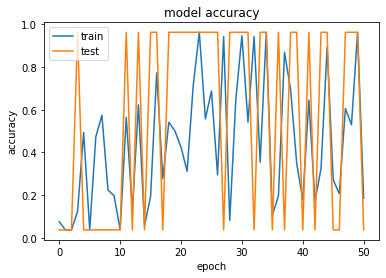

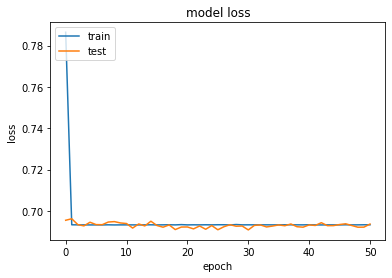

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 342, 50)           2800      
_________________________________________________________________
bidirectional (Bidirectional (None, 342, 448)          370944    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 768)               1921536   
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,393,841
Trainable params: 2,393,841
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


177/177 - 82s - loss: 0.6980 - accuracy: 0.4578 - val_loss: 0.6661 - val_accuracy: 0.5413
Epoch 2/100
177/177 - 74s - loss: 0.6940 - accuracy: 0.5485 - val_loss: 0.4917 - val_accuracy: 0.9180
Epoch 3/100
177/177 - 74s - loss: 0.6784 - accuracy: 0.6397 - val_loss: 0.6535 - val_accuracy: 0.6332
Epoch 4/100
177/177 - 73s - loss: 0.6620 - accuracy: 0.6539 - val_loss: 0.7130 - val_accuracy: 0.5244
Epoch 5/100
177/177 - 73s - loss: 0.6751 - accuracy: 0.5906 - val_loss: 0.7347 - val_accuracy: 0.5724
Epoch 6/100
177/177 - 73s - loss: 0.6669 - accuracy: 0.6252 - val_loss: 0.6523 - val_accuracy: 0.6671
Epoch 7/100
177/177 - 73s - loss: 0.6624 - accuracy: 0.6215 - val_loss: 0.8152 - val_accuracy: 0.4650
Epoch 8/100
177/177 - 73s - loss: 0.6612 - accuracy: 0.5291 - val_loss: 0.7841 - val_accuracy: 0.2071
Epoch 9/100
177/177 - 73s - loss: 0.6511 - accuracy: 0.6228 - val_loss: 0.6393 - val_accuracy: 0.5682
Epoch 10/100
177/177 - 73s - loss: 0.6620 - accuracy: 0.5749 - val_loss: 0.7698 - val_accuracy

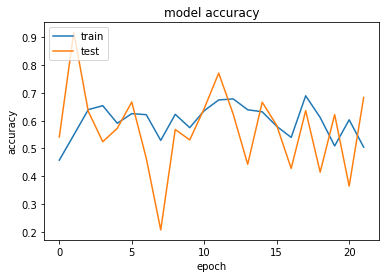

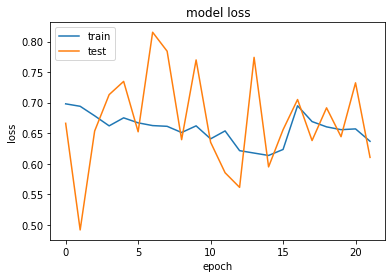

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 342, 50)           2800      
_________________________________________________________________
bidirectional (Bidirectional (None, 342, 256)          138240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 470,513
Trainable params: 470,513
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


177/177 - 53s - loss: 0.6955 - accuracy: 0.5004 - val_loss: 0.6629 - val_accuracy: 0.5979
Epoch 2/100
177/177 - 56s - loss: 0.6883 - accuracy: 0.5356 - val_loss: 0.7230 - val_accuracy: 0.5590
Epoch 3/100
177/177 - 60s - loss: 0.6703 - accuracy: 0.5906 - val_loss: 0.6440 - val_accuracy: 0.5845
Epoch 4/100
177/177 - 58s - loss: 0.6620 - accuracy: 0.5666 - val_loss: 0.7441 - val_accuracy: 0.5004
Epoch 5/100
177/177 - 58s - loss: 0.6627 - accuracy: 0.5906 - val_loss: 0.4745 - val_accuracy: 0.8686
Epoch 6/100
177/177 - 58s - loss: 0.6307 - accuracy: 0.6846 - val_loss: 0.5411 - val_accuracy: 0.7011
Epoch 7/100
177/177 - 58s - loss: 0.6293 - accuracy: 0.6364 - val_loss: 0.6325 - val_accuracy: 0.6078
Epoch 8/100
177/177 - 58s - loss: 0.6247 - accuracy: 0.6215 - val_loss: 0.5719 - val_accuracy: 0.6813
Epoch 9/100
177/177 - 58s - loss: 0.6001 - accuracy: 0.6866 - val_loss: 0.7194 - val_accuracy: 0.5435
Epoch 10/100
177/177 - 57s - loss: 0.5873 - accuracy: 0.6643 - val_loss: 0.7542 - val_accuracy

In [ ]:
#data_path = '/content/data/abl_kinase-data.csv'
#data_path = '/content/data/HIV.csv'
data_path = '/content/data/tox21.csv'




#, 'cnn-gru', 'gru', 'lstm'
#'cnn', 'cnn-gru', 'gru', 
model_list = ['cnn', 'cnn-gru', 'gru', 'lstm']
batch_size = 16
nb_epochs = 100
lr = 0.001
save_path = '/content/data'

WORK_DIRECTORY = '/content/data'

# Make save_path
# if save_path is not None:
#     os.makedirs(os.path.join(save_path, 'sequence_models'), exist_ok=True)

# Read data
smiles, y = read_data(data_path, col_smiles='smiles', col_target='SR-ATAD5')
tokens, num_words, max_phrase_len = generate_tokens(smiles, len_percentile=100)

# Get train and test set
X_train, X_test, y_train, y_test = train_test_split(tokens, y, test_size=TEST_RATIO, shuffle=True, stratify=y,
                                                  random_state=SEED)

# Build en evaluate graph models
model_scores = []
for model_type in model_list:
    model, scores = build_sequence_model((X_train, y_train), (X_test, y_test), model_type, num_words, max_phrase_len,
                                          output_dim=1, dropout_rate=0.2,
                                          batch_size=batch_size, nb_epochs=nb_epochs, lr=lr,
                             save_path=os.path.join(save_path, 'sequence_models', model_type + '.h5'))
    model_scores.append(scores)
        
    # force release memory
    K.clear_session()
    del model
    gc.collect()

model_df = pd.DataFrame({'model': model_list,
                    METRIC_ROC_AUC: [score[METRIC_ROC_AUC] for score in model_scores],
                    METRIC_F1_SCORE: [score[METRIC_F1_SCORE] for score in model_scores]                
                      })
model_df = model_df[['model', METRIC_ROC_AUC, METRIC_F1_SCORE]]


model_df.to_csv(os.path.join(WORK_DIRECTORY, 'summary_sequence_model.csv'), index=False)
model_df.sort_values(by=[METRIC_ROC_AUC, METRIC_F1_SCORE],
                      ascending=False, inplace=True)
print('Best model:\n' + str(model_df.iloc[0]))

print(model_df)


model_df.style.background_gradient(cmap='coolwarm',axis=0)

import seaborn as sns

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
sns.set_style('ticks')


def normalized_confusion_matrix(y_test, conf_mat, model):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = (conf_mat.T/counts).T
    plt.figure(figsize=(6,5))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,annot_kws={'size':20},lw=2, cbar=True, cbar_kws={'label':'% Class accuracy'})
    plt.title(f'Confusion Matrix ({model})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20) ##colorbar label
    cax = plt.gcf().axes[-1]  ##colorbar ticks
    cax.tick_params(labelsize=20) ## colorbar ticks
    plt.savefig(f'confusion-matrix-{model}.png',dpi=300)

i = 0
for score in model_scores:
  conf_mat = score[METRIC_CONFUSION_MATRIX]
  normalized_confusion_matrix(y_test,conf_mat, model_list[i])
  i = i + 1


!cp -r /content/data /content/drive/MyDrive/sequenceModelResults0




In [ ]:
model_df.style.background_gradient(cmap='coolwarm',axis=0)


,model,ROC_AUC,f1-score
2,gru,0.719842,0.631499
3,lstm,0.697559,0.594452
0,cnn,0.664450,0.625490
1,cnn-gru,0.559423,0.486700


In [ ]:
import seaborn as sns

In [ ]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
sns.set_style('ticks')

In [ ]:
def normalized_confusion_matrix(y_test, conf_mat, model):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = (conf_mat.T/counts).T
    plt.figure(figsize=(6,5))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,annot_kws={'size':20},lw=2, cbar=True, cbar_kws={'label':'% Class accuracy'})
    plt.title(f'Confusion Matrix ({model})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20) ##colorbar label
    cax = plt.gcf().axes[-1]  ##colorbar ticks
    cax.tick_params(labelsize=20) ## colorbar ticks
    plt.savefig(f'confusion-matrix-{model}.png',dpi=300)

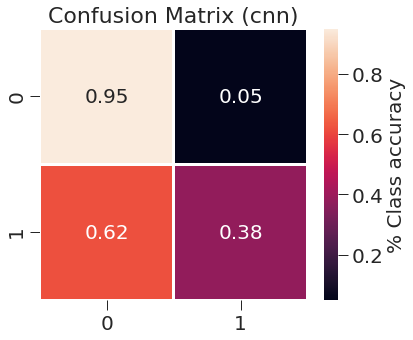

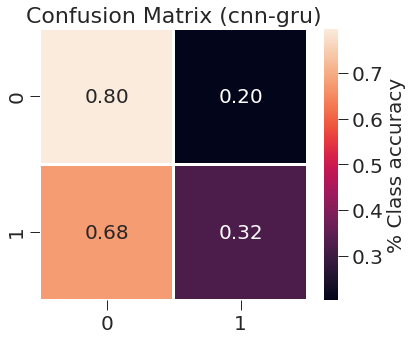

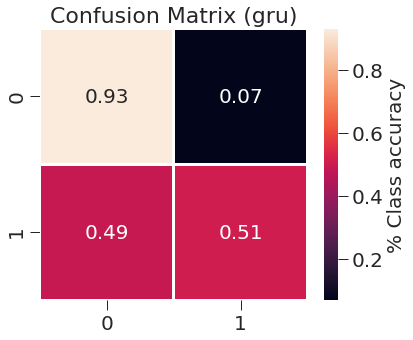

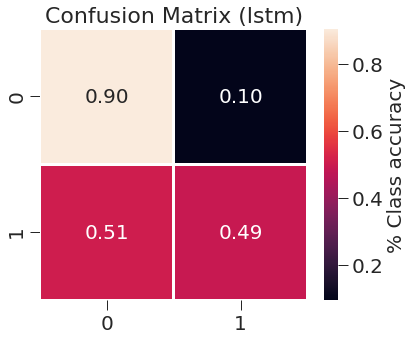

In [ ]:
i = 0
for score in model_scores:
  conf_mat = score[METRIC_CONFUSION_MATRIX]
  normalized_confusion_matrix(y_test,conf_mat, model_list[i])
  i = i + 1
